# Build Logistic Regression Models

## Import Processed Data

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
# set path of the processed data
processed_data_path = Path.cwd().parent / 'data' / 'processed'
train_processed_file_path = processed_data_path /'train_processed_for_pca.csv'
test_processed_file_path = processed_data_path / 'test_processed_for_pca.csv'
unlabeled_processed_file_path = processed_data_path / 'unlabeled_processed_for_pca.csv'

# create data frames for train, test, and unlabled data
train_df = pd.read_csv(train_processed_file_path, index_col = 'PassengerId')
test_df = pd.read_csv(test_processed_file_path, index_col = 'PassengerId')
unlabeled_df = pd.read_csv(unlabeled_processed_file_path, index_col = 'PassengerId')

In [3]:
# in the train and test data, X contains all the columns except Survived
# y is Survived
X_train = train_df.drop(['Survived'], axis = 1)
y_train = train_df['Survived']
X_test = test_df.drop(['Survived'], axis = 1)
y_test = test_df['Survived']

## PCA

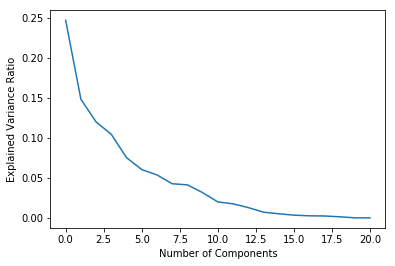

In [4]:
# let's look at how explained variance ratio varies with number of components
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA(random_state = 42)
pca.fit(X_train)

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [5]:
# it looks like we can get away with using about 13 components
pca = PCA(n_components = 13,
          random_state = 42).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
unlabeled_pca = pca.transform(unlabeled_df)

## Default Logistic Regression

In [6]:
# use 5-fold CV to evaluate accuracy with train data
model = LogisticRegression(random_state = 42)
scores = cross_val_score(model, X_train_pca, y_train, cv = 5)

print('CV accuracty mean: ' + '{0:2f}'.format(scores.mean()))
print('CV accuracty std: ' + '{0:2f}'.format(scores.std()))
print('CV scores:', scores)

CV accuracty mean: 0.801946
CV accuracty std: 0.026103
CV scores: [0.77622378 0.78321678 0.84615385 0.81690141 0.78723404]


## Tuned Logistic Regression with l1 penalty

In [7]:
# define the parameter values that will be considered
C_vals = [2**i for i in range(-10,5)]
solvers = ['liblinear', 'saga']
params = {'C' : C_vals,
          'solver' : solvers}

# used to evaluate all possible combinations with 5-fold cross-validation
grid_search = GridSearchCV(LogisticRegression(random_state = 42, 
                                              penalty = 'l1',
                                              max_iter = 300),
                           param_grid = params,
                           cv = 5,
                           refit = True,
                           return_train_score = True)

# fit
grid_search.fit(X_train_pca, y_train)

# return the optimal combo of parameters and its score
print(grid_search.best_params_, '\n')
print(grid_search.best_score_)

{'C': 0.0625, 'solver': 'saga'} 

0.8089887640449438


In [8]:
# use 5-fold CV to evaluate accuracy with train data
model = LogisticRegression(random_state = 42,
                           C = 0.0625,
                           solver = 'saga',
                           penalty = 'l1',
                           max_iter = 300)
scores = cross_val_score(model, X_train_pca, y_train, cv = 5)

print('CV accuracty mean: ' + '{0:2f}'.format(scores.mean()))
print('CV accuracty std: ' + '{0:2f}'.format(scores.std()))
print('CV scores:', scores)

CV accuracty mean: 0.808978
CV accuracty std: 0.024962
CV scores: [0.7972028  0.78321678 0.83216783 0.84507042 0.78723404]


## Tuned Logistic Regression with l2 penalty

In [9]:
# define the parameter values that will be considered
C_vals = [2**i for i in range(-10,5)]
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
params = {'C' : C_vals,
          'solver' : solvers}

# used to evaluate all possible combinations with 5-fold cross-validation
grid_search = GridSearchCV(LogisticRegression(random_state = 42, 
                                              penalty = 'l2',
                                              max_iter = 300),
                           param_grid = params,
                           cv = 5,
                           refit = True,
                           return_train_score = True)

# fit
grid_search.fit(X_train_pca, y_train)

# return the optimal combo of parameters and its score
print(grid_search.best_params_, '\n')
print(grid_search.best_score_)

{'C': 0.015625, 'solver': 'newton-cg'} 

0.8089887640449438


In [10]:
# use 5-fold CV to evaluate accuracy with train data
model = LogisticRegression(random_state = 42,
                           C = 0.015625,
                           solver = 'newton-cg',
                           penalty = 'l2',
                           max_iter = 300)
scores = cross_val_score(model, X_train_pca, y_train, cv = 5)

print('CV accuracty mean: ' + '{0:2f}'.format(scores.mean()))
print('CV accuracty std: ' + '{0:2f}'.format(scores.std()))
print('CV scores:', scores)

CV accuracty mean: 0.808959
CV accuracty std: 0.024759
CV scores: [0.81118881 0.78321678 0.82517483 0.84507042 0.78014184]


## Kaggle Score: 0.75598

Before we "go live" with this model (that is, submit its predictions to Kaggle), let's check how it performs on the test data, data that it has never seen and had no influence on its selection:

In [11]:
# fit model to entire train set
model = LogisticRegression(random_state = 42,
                           C = 0.0625,
                           solver = 'saga',
                           penalty = 'l1',
                           max_iter = 300).fit(X_train_pca, y_train)

# evaluate accuracy on test set
print('Tuned LogReg (w/PCA) Accuracy: ' + '{0:2f}'.format(model.score(X_test_pca, y_test)))

Tuned LogReg (w/PCA) Accuracy: 0.776536


In [12]:
# generate predictions
predictions = model.predict(unlabeled_pca)

# create a new data frame with two columns: PassengerId and our predicted values for Survived
submission_df = pd.DataFrame({'PassengerId' : unlabeled_df.index, 'Survived' : predictions})

# write submission to disk...
# first define path
submission_file_path = Path.cwd().parent / 'data' / 'external' / 'logreg_with_pca.csv'

# create the .csv file
# index is False since we don't want a third column
submission_df.to_csv(submission_file_path, index = False)

## Model Persistence

In [13]:
# create file path
model_file_path = Path.cwd().parent / 'models' / 'logreg_with_pca_model.pkl'

# persist the model
joblib.dump(model, model_file_path);

#### Optional: Check the persisted model

In [14]:
# create file paths
model_file_path = Path.cwd().parent / 'models' / 'logreg_with_pca_model.pkl'

# load
model_loaded = joblib.load(model_file_path)

In [15]:
# print the model object description
model_loaded

LogisticRegression(C=0.0625, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=300,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [16]:
# calculate the score using the loaded model object
# we should get 0.776536, as above
print('Persisted LogReg (w/PCA) Accuracy: ' + '{0:2f}'.format(model_loaded.score(X_test_pca, y_test)))

Persisted LogReg (w/PCA) Accuracy: 0.776536


## Error Analysis

In [17]:
# imports
from sklearn.model_selection import cross_val_predict

In [18]:
# instead of scoring, get the cross-validated estimates for each image
y_train_pred = cross_val_predict(model, X_train_pca, y_train, cv = 5)

In [19]:
# now let's take a look at the confusion matrix to see
# which actual labels (rows) do not match the predicted label (columns)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

conf_mx = confusion_matrix(y_train, y_train_pred)
print(np.matrix(conf_mx))
print('Precision score: ', precision_score(y_train, y_train_pred))
print('Recall score: ', recall_score(y_train, y_train_pred))
print('F1 score: ', f1_score(y_train, y_train_pred))
print('Area under the ROC curve: ', roc_auc_score(y_train, y_train_pred))

[[384  55]
 [ 81 192]]
Precision score:  0.7773279352226721
Recall score:  0.7032967032967034
F1 score:  0.7384615384615386
Area under the ROC curve:  0.7890059826278506


In [20]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

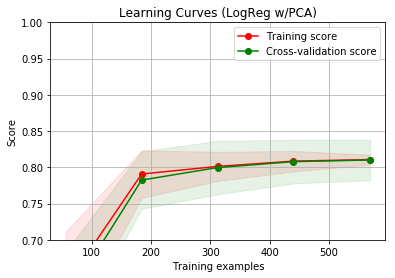

In [21]:
title = "Learning Curves (LogReg w/PCA)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(model, title, X_train_pca, y_train, ylim=(0.7, 1.0), cv=cv, n_jobs=-1);

Huh. The Kaggle score was worse, but the learning curves seem to suggest that the model is not overfitting. I'm getting tired, so I'll bang out the voting classifier and look at this tomorrow with fresh eyes.